In [1]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from typing import Callable, Optional
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import torch.nn.functional as F
import pandas as pd
import numpy as np
from celluloid import Camera
from thinker.actor_net import DRCNet
import os
import random
from thinker.actor_net import sample

/home/tom/mlmi/dissertation/working_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-01 11:08:55,376	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



## Setup

In [2]:
class ProbingDataset(Dataset):
    def __init__(self, data: list):
        self.data = data
    def __len__(self) -> int:
        return len(self.data)
    def __getitem__(self, index: int) -> dict:
        return self.data[index]
    def get_feature_range(self, feature: str) -> tuple[int, int]:
        assert feature in self.data[0].keys(), f"Please enter a feature in dataset: {self.data[0].keys()}"
        min_feature_value, max_feature_value = self.data[0][feature], self.data[0][feature]
        for entry in self.data:
            if entry[feature] > max_feature_value:
                max_feature_value = entry[feature]
            elif entry[feature] < min_feature_value:
                min_feature_value = entry[feature]
        return (min_feature_value, max_feature_value)


class ProbingDatasetCleaned(Dataset):
    def __init__(self, data: list):
        self.data = data
    def __len__(self) -> int:
        return len(self.data)
    def __getitem__(self, index: int) -> tuple:
        return self.data[index]

In [3]:
val_data = torch.load("../probing/data/train_data_random.pt")

In [4]:
# summarise dist of values
vals = []
for trans in val_data:
    vals +=[trans["value"]] 
print(sum(vals) / len(vals), max(vals), min(vals))

7.4155424255886135 11.626 1.286


In [5]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False
envname = f"compare_cutoffpush_0"

env = thinker.make(
    f"Sokoban-cutoffpush_clean_0016-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset()
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)

Initializing env 0 with device cpu


Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


In [6]:
# get averages
avg_activs = torch.zeros_like(val_data[0]["hidden_states"][-1,160:192,:,:])
avg_xencs = torch.zeros_like(val_data[0]["hidden_states"][-1,192:224,:,:])
for trans in val_data:
    avg_activs += trans["hidden_states"][-1,160:192,:,:]
    avg_xencs += trans["hidden_states"][-1,192:,:,:]
avg_activs = avg_activs / len(val_data)
avg_xencs = avg_xencs / len(val_data)

## Value Lens

In [7]:
# value head version of logit lens
class ValueLens(nn.Module):
    def __init__(self, drc_net, avg_activs=None, avg_xencs=None, mode="hidden"):
        super().__init__()
        assert mode in ["cell", "hidden"]
        self.final_layer = drc_net.final_layer
        self.policy = drc_net.policy
        self.value_head = drc_net.baseline
        self.dim_actions = drc_net.dim_actions
        self.num_Actions = drc_net.num_actions
        self.avg_activs = avg_activs
        self.avg_xencs = avg_xencs
        self.avg_patch = False
        self.tick = 3
        self.mode = mode

    def forward(self, hidden_state):

        if self.mode == "cell":
            c_new = hidden_state[:,self.tick,160:192,:,:]
            core_output = torch.tanh(c_new) * hidden_state[:,self.tick,-64:-32,:,:]
        elif self.mode == "hidden":
            core_output = hidden_state[:,self.tick,128:160,:,:]

        x_enc = hidden_state[:,self.tick,192:224,:,:]

        if self.avg_patch:
            core_output[:,:,:,:] = self.avg_activs
            x_enc[:,:,:,:] = self.avg_xencs

        core_output = torch.cat([x_enc, core_output], dim=1)
        core_output = torch.flatten(core_output, 1)

        final_out = F.relu(drc_net.final_layer(core_output))
        return self.value_head(final_out).view(x_enc.shape[0], 1)

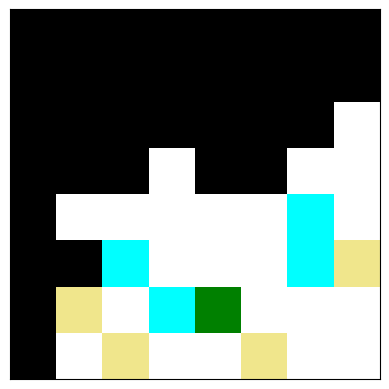

tensor([[[7.4346]]], grad_fn=<ViewBackward0>)
tensor([[7.4346]], grad_fn=<ViewBackward0>)


In [8]:
# test in hidden mode
value_lens = ValueLens(drc_net, avg_activs, avg_xencs, "hidden")
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state, reward, done, info = env.step(actor_out.action)
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
viz.plot_mini_sokoban(state["real_states"][0])
print(actor_out.baseline)

hidden_states = drc_net.hidden_state
print(value_lens(hidden_states))

In [7]:
# test in cell mode
value_lens = ValueLens(drc_net, avg_activs, avg_xencs, "cell")
drc_net.record_gates = True
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state, reward, done, info = env.step(actor_out.action)
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
viz.plot_mini_sokoban(state["real_states"][0])
print(actor_out.baseline)

gates = torch.cat([torch.zeros_like(drc_net.core.gates[0]).unsqueeze(0), drc_net.core.gates], dim=0)
hidden_states = torch.cat([drc_net.hidden_state, gates.unsqueeze(0)],dim=2)
print(value_lens(hidden_states))

NameError: name 'drc_net' is not defined

## Integrated Gradients

In [8]:
from captum.attr import IntegratedGradients

### On Hidden States

In [9]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False
env = thinker.make(
    f"Sokoban-cutoffpush_clean_0016-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset()
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


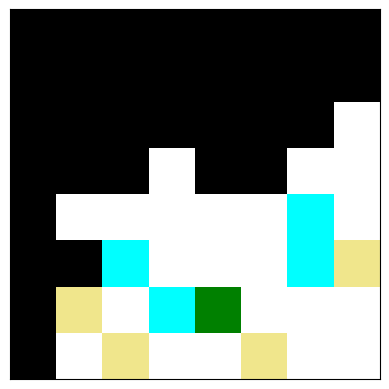

In [10]:
value_lens = ValueLens(drc_net, avg_activs, avg_xencs, "hidden")
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state, reward, done, info = env.step(actor_out.action)
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
viz.plot_mini_sokoban(state["real_states"][0])

In [11]:
int_grad_at = IntegratedGradients(value_lens)
baselines = drc_net.hidden_state.clone()
baselines[:,-1,192:,:,:] = avg_xencs
baselines[:,-1,128:160,:,:] = avg_activs
hidden_states = drc_net.hidden_state.clone()
x = int_grad_at.attribute(inputs=hidden_states, baselines=baselines)

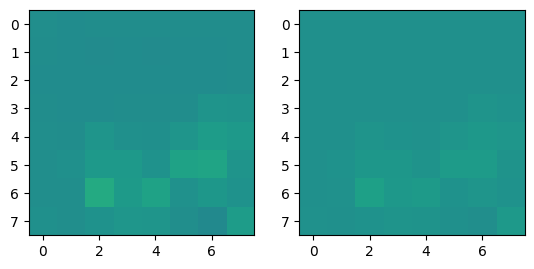

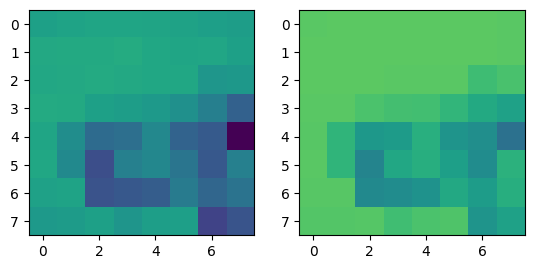

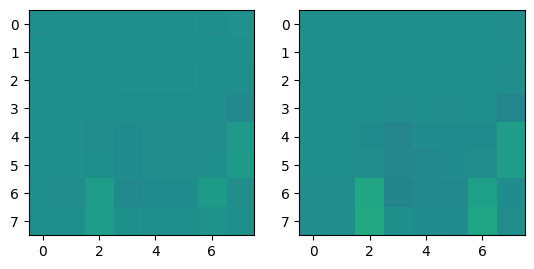

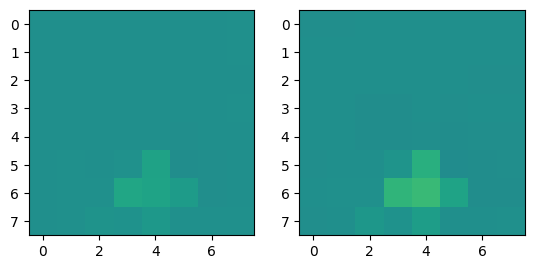

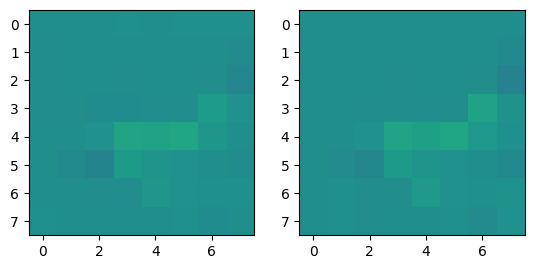

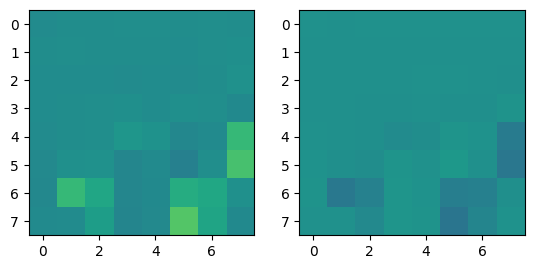

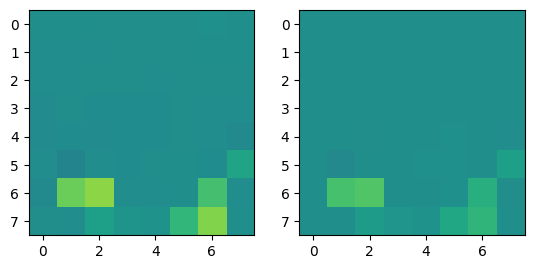

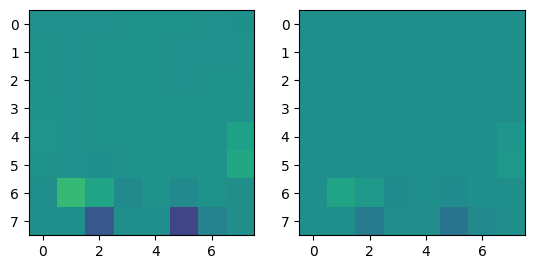

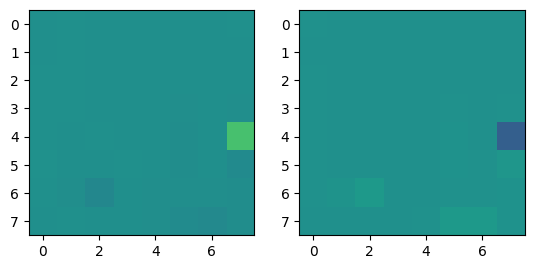

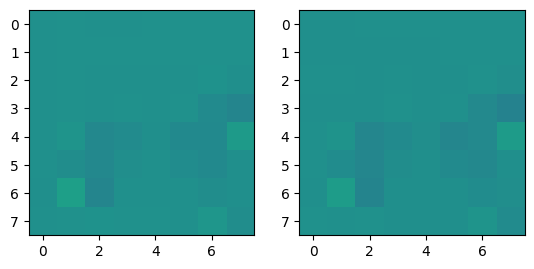

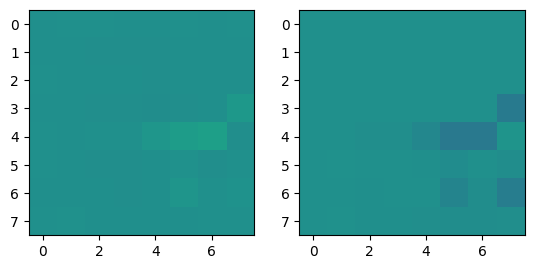

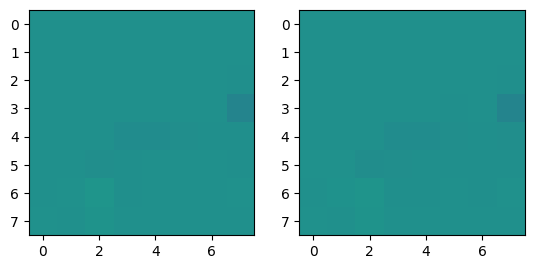

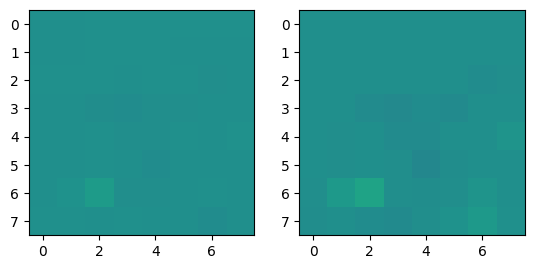

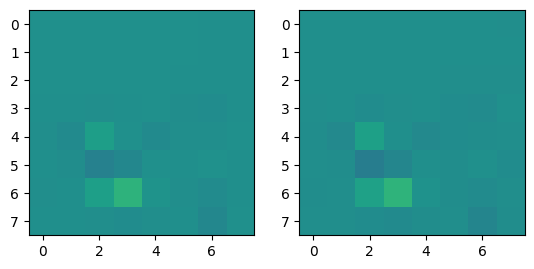

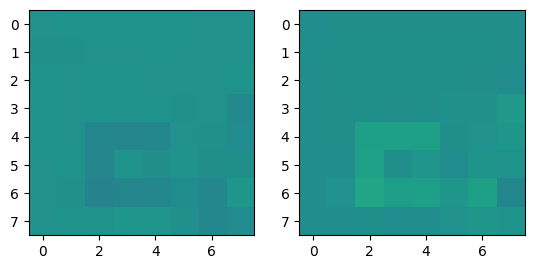

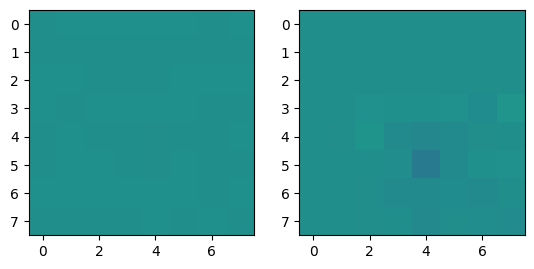

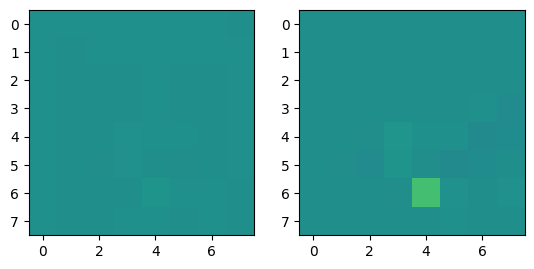

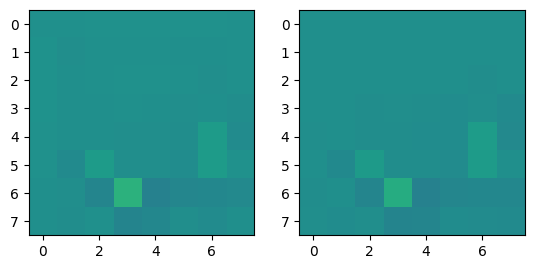

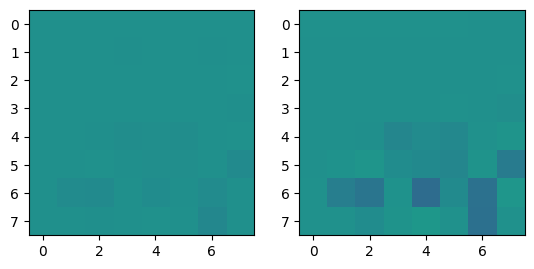

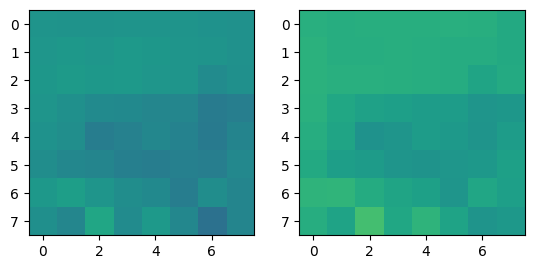

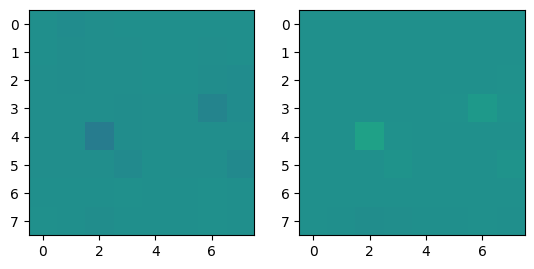

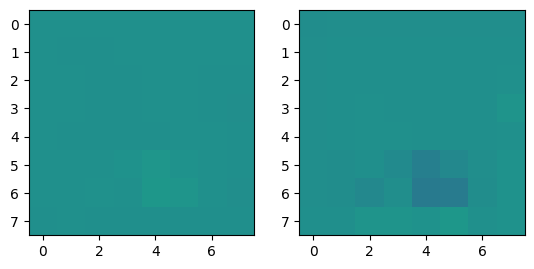

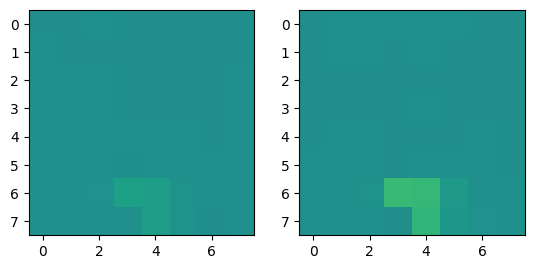

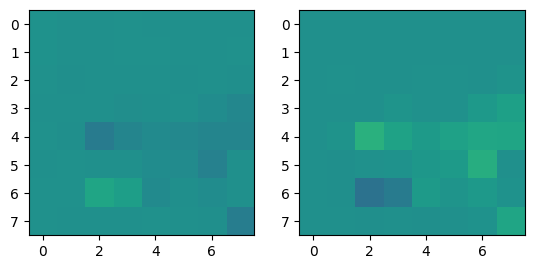

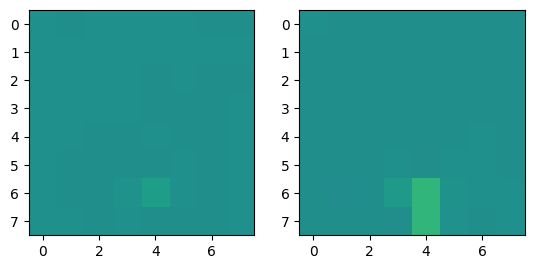

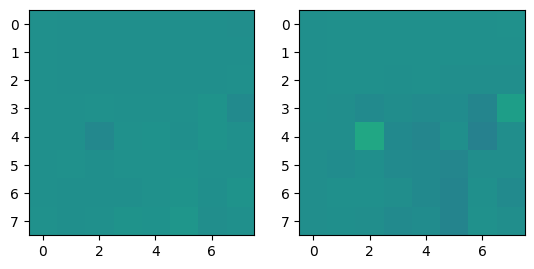

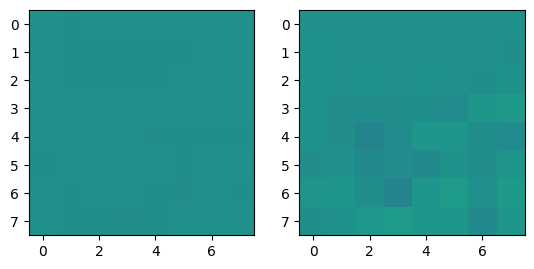

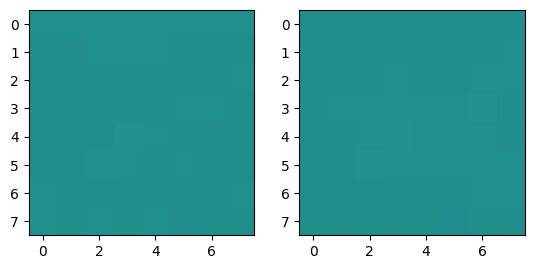

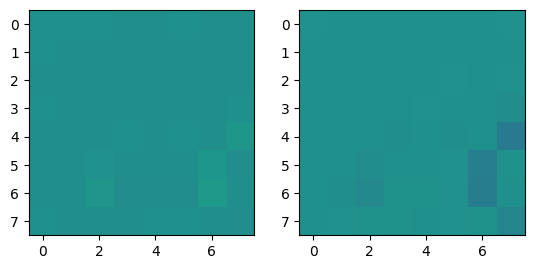

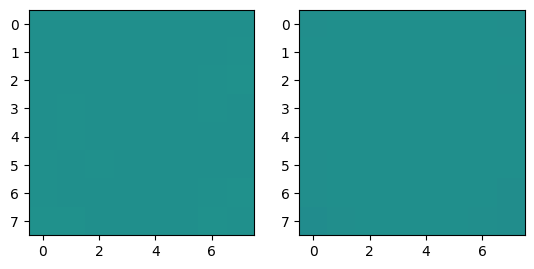

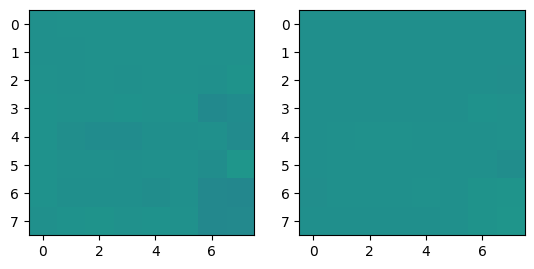

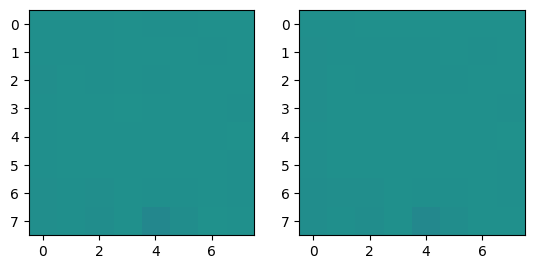

In [12]:
for i in range(32):
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(x[0,-1,128+i,:,:].detach(), vmin=-0.15, vmax=0.15)
    axs[1].imshow(drc_net.hidden_state[0,-1,128+i,:,:].detach(), vmin=-2, vmax=2)
    plt.show()

### On Cell

In [39]:
env_n = 1
gpu = False
mini_sokoban = True 
mini_unqtar = False
mini_unqbox = False
envname = f"compare_cutoffpush_0"

env = thinker.make(
    f"Sokoban-cutoffpush_clean_0024-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, 
    has_model=False, 
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban,
    mini_unqtar=mini_unqtar,
    mini_unqbox=mini_unqbox         
    ) 
flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) 
flags.mini = mini_sokoban
flags.mini_unqbtar = mini_unqtar
flags.mini_unqbox = mini_unqbox
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset()
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False)
#actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


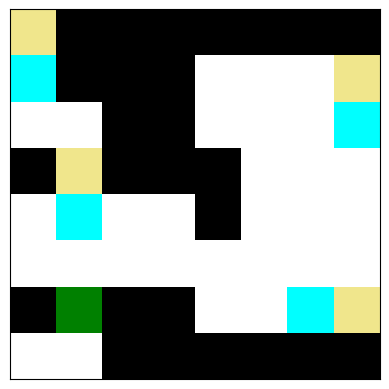

tensor([[[5.4162]]], grad_fn=<ViewBackward0>)


In [43]:
value_lens = ValueLens(drc_net, avg_activs, avg_xencs, "cell")
drc_net.record_gates = True
actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
state, reward, done, info = env.step(actor_out.action)
env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
viz.plot_mini_sokoban(state["real_states"][0])

gates = torch.cat([torch.zeros_like(drc_net.core.gates[0]).unsqueeze(0), drc_net.core.gates], dim=0)
hidden_states = torch.cat([drc_net.hidden_state, gates.unsqueeze(0)],dim=2)
print(actor_out.baseline)

In [44]:
int_grad_at = IntegratedGradients(value_lens)
baselines = hidden_states.clone()
baselines[:,-1,192:224,:,:] = avg_xencs
baselines[:,-1,160:192,:,:] = avg_activs
x = int_grad_at.attribute(inputs=hidden_states, baselines=baselines)

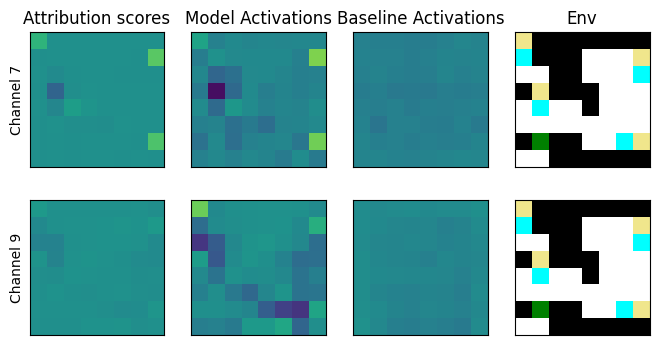

In [45]:
channels = [7,9]
fig, axs = plt.subplots(len(channels),4, figsize=(8,2*len(channels)))

state_c = state["real_states"][0].permute(1,2,0)
dim_z = 7
mini_board = np.zeros(state_c.shape[:-1])
for i in range(1,1+dim_z):
    mini_board[(state_c[:,:,i-1] == 1)] = i
mini_board = np.flip(mini_board, axis=0)
cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
bounds= [i+0.5 for i in range(1+dim_z)]
norm = colors.BoundaryNorm(bounds, cmap.N)

for i in range(len(channels)):
    axs[i][0].imshow(x[0,-1,160+channels[i],:,:].detach(), vmin=-0.25, vmax=0.25)
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][1].imshow(drc_net.hidden_state[0,-1,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][0].set_ylabel(f"Channel {channels[i]}")
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])
    axs[i][2].imshow(avg_activs[channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][2].set_xticks([])
    axs[i][2].set_yticks([])
    board_img = axs[i][3].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)

axs[0][0].set_title("Attribution scores")
axs[0][1].set_title("Model Activations")
axs[0][2].set_title("Baseline Activations")
axs[0][3].set_title("Env")
plt.show()

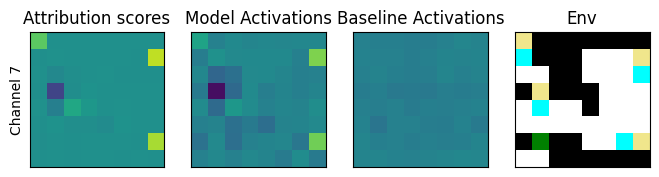

In [48]:
channels = [7]
fig, axs = plt.subplots(1,4, figsize=(8,8))
for i in range(len(channels)):
    axs[0].imshow(x[0,-1,160+channels[i],:,:].detach(), vmin=-0.15, vmax=0.15)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title("Attribution Scores")
    axs[1].imshow(drc_net.hidden_state[0,-1,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[0].set_ylabel(f"Channel {channels[i]}")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_title("Actual Activations")
    axs[2].imshow(avg_activs[channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    axs[2].set_title("Baseline Activations")
    state_c = state["real_states"][0].permute(1,2,0)
    dim_z = 7
    mini_board = np.zeros(state_c.shape[:-1])
    for i in range(1,1+dim_z):
        mini_board[(state_c[:,:,i-1] == 1)] = i
    mini_board = np.flip(mini_board, axis=0)
    cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
    bounds= [i+0.5 for i in range(1+dim_z)]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    board_img = axs[3].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[3].set_title("Env State")
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)


axs[0].set_title("Attribution scores")
axs[1].set_title("Model Activations")
axs[2].set_title("Baseline Activations")
axs[3].set_title("Env")
plt.show()

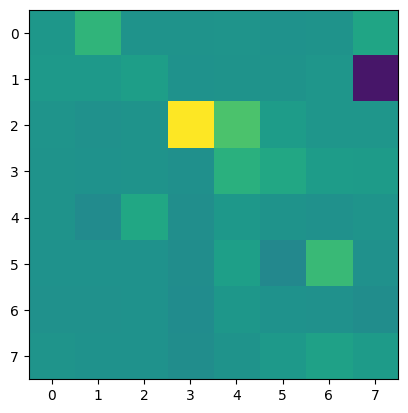

In [48]:
plt.imshow(drc_net.hidden_state[0,-1,160+20,:,:].detach(), vmin=-1, vmax=1)

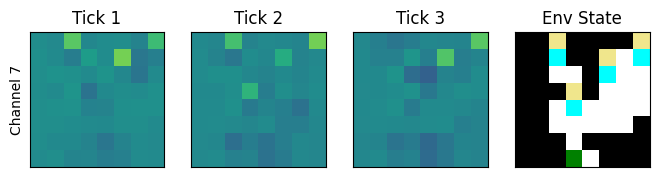

In [28]:
channels = [7]
fig, axs = plt.subplots(1,4, figsize=(8,8))
for i in range(len(channels)):
    axs[0].imshow(drc_net.hidden_state[0,1,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title("Tick 1")
    axs[1].imshow(drc_net.hidden_state[0,2,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[0].set_ylabel(f"Channel {channels[i]}")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_title("Tick 2")
    axs[2].imshow(drc_net.hidden_state[0,3,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    axs[2].set_title("Tick 3")
    state_c = state["real_states"][0].permute(1,2,0)
    dim_z = 7
    mini_board = np.zeros(state_c.shape[:-1])
    for i in range(1,1+dim_z):
        mini_board[(state_c[:,:,i-1] == 1)] = i
    mini_board = np.flip(mini_board, axis=0)
    cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
    bounds= [i+0.5 for i in range(1+dim_z)]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    board_img = axs[3].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[3].set_title("Env State")
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)

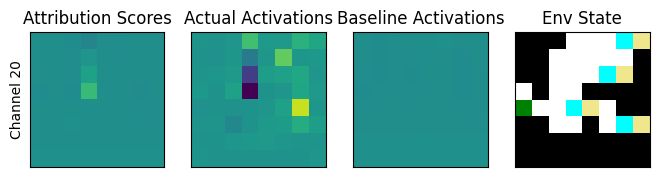

In [640]:
channels = [20]
fig, axs = plt.subplots(1,4, figsize=(8,8))
for i in range(len(channels)):
    axs[0].imshow(x[0,-1,160+channels[i],:,:].detach(), vmin=-0.15, vmax=0.15)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title("Attribution Scores")
    axs[1].imshow(drc_net.hidden_state[0,-1,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[0].set_ylabel(f"Channel {channels[i]}")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_title("Actual Activations")
    axs[2].imshow(avg_activs[channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    axs[2].set_title("Baseline Activations")
    state_c = state["real_states"][0].permute(1,2,0)
    dim_z = 7
    mini_board = np.zeros(state_c.shape[:-1])
    for i in range(1,1+dim_z):
        mini_board[(state_c[:,:,i-1] == 1)] = i
    mini_board = np.flip(mini_board, axis=0)
    cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
    bounds= [i+0.5 for i in range(1+dim_z)]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    board_img = axs[3].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    axs[3].set_title("Env State")
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)

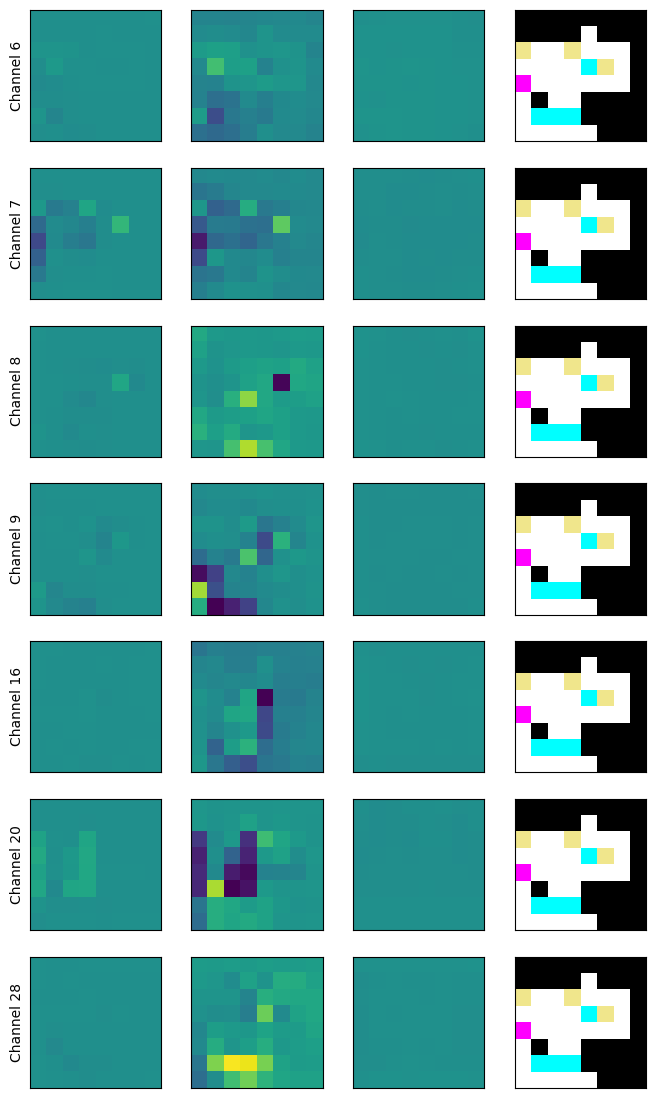

In [704]:
channels = [6,7,8,9,16,20,28]
fig, axs = plt.subplots(len(channels),4, figsize=(8,2*len(channels)))

state_c = state["real_states"][0].permute(1,2,0)
dim_z = 7
mini_board = np.zeros(state_c.shape[:-1])
for i in range(1,1+dim_z):
    mini_board[(state_c[:,:,i-1] == 1)] = i
mini_board = np.flip(mini_board, axis=0)
cmap = colors.ListedColormap(['black', "white", "aqua", "gold", "green","magenta", "khaki"])
bounds= [i+0.5 for i in range(1+dim_z)]
norm = colors.BoundaryNorm(bounds, cmap.N)

for i in range(len(channels)):
    axs[i][0].imshow(x[0,-1,160+channels[i],:,:].detach(), vmin=-0.25, vmax=0.25)
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][1].imshow(drc_net.hidden_state[0,-1,160+channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][0].set_ylabel(f"Channel {channels[i]}")
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])
    axs[i][2].imshow(avg_activs[channels[i],:,:].detach(), vmin=-1, vmax=1)
    axs[i][2].set_xticks([])
    axs[i][2].set_yticks([])
    board_img = axs[i][3].imshow(mini_board, interpolation='nearest', origin='lower', cmap=cmap, norm=norm)
    board_img.axes.get_yaxis().set_visible(False)
    board_img.axes.get_xaxis().set_visible(False)
plt.show()

In [56]:
attrib_results = x[0,-1,160:192,:,:].detach().clone()
attrib_pos = np.maximum(attrib_results, 0)
attrib_neg = -np.maximum(-attrib_results, 0)

In [35]:
b = [0.1582038700580597, -1.3942620754241943, 0.0007461070781573653, 0.29835984110832214, 0.9219281077384949, -0.18776537477970123, 0.08432460576295853,
      0.2601940333843231, -0.21610066294670105, -0.4587389826774597, -0.4523847997188568, 0.12008322775363922, 0.17409302294254303, 0.2926468551158905,
        1.5992499589920044, -0.11713918298482895, 0.36193913221359253, 0.24208196997642517, 0.17022369801998138, 0.1348171830177307, 0.04060109332203865, 
        -0.06143619865179062, 0.010853596031665802, 0.11437692493200302, 0.06493567675352097, 0.47768354415893555, -0.18594540655612946, 0.16309306025505066, 
        -0.337173193693161, -0.08848776668310165, 0.01659984141588211, 0.03852769732475281]

In [29]:
b = np.array(b)

In [30]:
b_hat = b / np.sqrt(np.sum(b**2))

In [84]:
test = torch.zeros((8,8))
for i in range(8):
    for j in range(8):
        test[i,j] = np.dot(attrib_neg[:,i,j], b_hat)
        #test[i,j] = x[0,-1,129,i,j].detach().numpy().item()

In [73]:
attrib_results.sum()

tensor(1.9377, dtype=torch.float64)

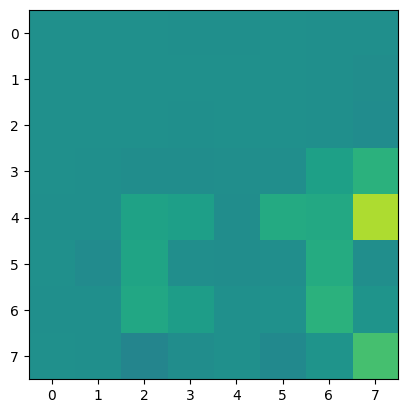

In [85]:
plt.imshow(test, vmin=-0.1, vmax=0.1)

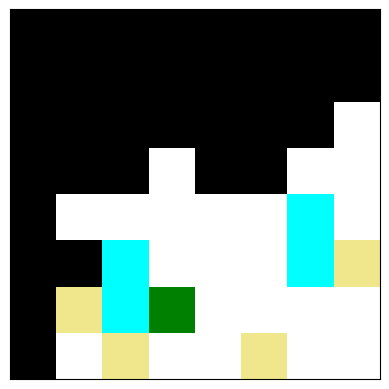

In [38]:
viz.plot_mini_sokoban(state["real_states"][0])

## Regression

In [ ]:
from scipy import stats

In [87]:
weight2 = torch.tensor([[-0.48737913370132446, 2.0204238891601562, -0.20710276067256927, -0.1559930294752121, -1.4778072834014893, 1.0226231813430786, -0.011008787900209427, 0.26454436779022217,
                             0.5662028789520264, 0.826072633266449, 0.7518832087516785, 0.4854520261287689, -0.545423686504364, -0.1605425626039505, -2.30305552482605, 0.10711660981178284,
                               -0.20925910770893097, -0.4371994435787201, -0.09227673709392548, 0.2594224214553833, 0.09071329236030579, -0.10446739196777344, -0.008032598532736301, -0.6721022725105286, 
                               0.14969028532505035, -0.5917406678199768, 0.7830581068992615, -0.018811164423823357, 0.2390570491552353, 0.2955656945705414, -1.1725964546203613, 0.9227076768875122],
                                 [0.6500030755996704, -1.9482715129852295, 0.21371221542358398, -0.007815630175173283, 1.2696133852005005, -0.7610629200935364, 0.0742838978767395, -0.525004506111145, 
                                  -0.3204478919506073, -0.8447422981262207, -0.5190479755401611, -0.7739930152893066, 0.6830257177352905, 0.15014739334583282, 2.5916659832000732, -0.32344695925712585, 
                                  0.09805583208799362, 0.6653913259506226, 0.010809963569045067, -0.0951007530093193, 0.04532609134912491, -0.021794166415929794, 0.18280953168869019, 0.7764242887496948, 
                                  -0.0533781498670578, 0.40867361426353455, -0.7241909503936768, 0.18064184486865997, -0.30017533898353577, -0.36463192105293274, 1.2368476390838623, -0.9249445199966431]])

In [77]:
vals = []
plans = []

channels = list(range(32))

for trans in val_data:
    map2 = torch.zeros(size=(2,8,8))
    for i in range(len(channels)):
        map2[0] += trans["hidden_states"][-1,160+channels[i],:,:] * weight2[0,i]
        map2[1] += trans["hidden_states"][-1,160+channels[i],:,:] * weight2[1,i]
    vals.append(trans["value"])
    plans.append(map2.argmax(dim=0).sum().item())

vals = np.array(vals)
plans = np.array(plans)

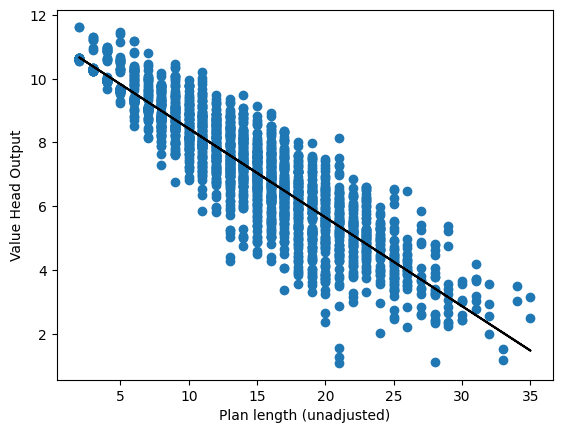

In [78]:
slope, intercept, r, p, std_err = stats.linregress(plans, vals)

def condi_expec_fnc(x):
  return slope * x + intercept

cef = list(map(condi_expec_fnc, plans))

plt.scatter(plans, vals)
plt.plot(plans, cef, color="black")

plt.xlabel("Plan length (unadjusted)")
plt.ylabel("Value Head Output")
plt.show() 

In [38]:
gamma = 0.97
discounted_plans = np.array([sum([gamma**i for i in range(p+1)]) for p in plans])

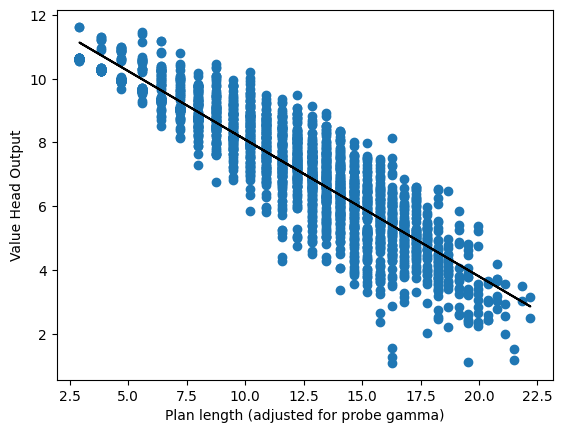

In [39]:
slope, intercept, r, p, std_err = stats.linregress(discounted_plans, vals)

def condi_expec_fnc(x):
  return slope * x + intercept

cef = list(map(condi_expec_fnc, discounted_plans))

plt.scatter(discounted_plans, vals)
plt.plot(discounted_plans, cef, color="black")

plt.xlabel("Plan length (adjusted for probe gamma)")
plt.ylabel("Value Head Output")
plt.show() 

In [90]:
vals = []
plans = []

channels = list(range(32))

for trans in val_data:
    map2 = torch.zeros(size=(2,8,8))
    for i in range(len(channels)):
        map2[0] += trans["hidden_states"][-1,160+channels[i],:,:] * weight2[0,i]
        map2[1] += trans["hidden_states"][-1,160+channels[i],:,:] * weight2[1,i]
    vals.append(trans["value"])
    plans.append(map2.softmax(dim=0)[1].sum().item())

vals = np.array(vals)
plans = np.array(plans)

In [94]:
slope, intercept, r, p, std_err = stats.linregress(plans, vals)

def condi_expec_fnc(x):
  return slope * x + intercept

cef = list(map(condi_expec_fnc, plans))

plt.scatter(plans, vals)
plt.plot(plans, cef, color="black")

plt.xlabel("Sum of plan probabilities")
plt.ylabel("Value Head Output")
plt.show() 

NameError: name 'stats' is not defined

In [95]:
from sklearn import linear_model

In [96]:
reg = linear_model.LinearRegression()
reg.fit(plans, vals)

LinearRegression()

ValueError: x and y must be the same size

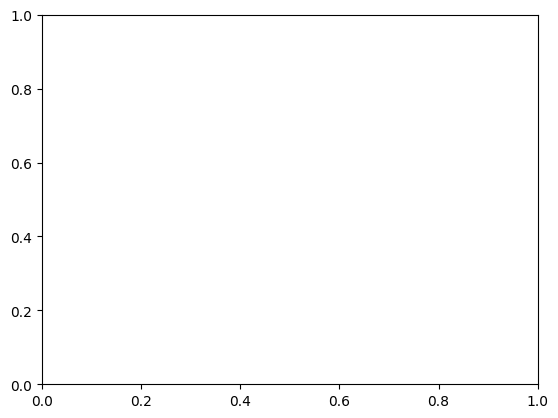

In [97]:
plt.scatter(plans, vals)
plt.plot([reg.predict([[i]])[0] for i in np.linspace(start=2,stop=30)])

In [91]:
vals = []
plans = []

channels = list(range(32))

for trans in val_data:
    map2 = torch.zeros(size=(2,8,8))
    for i in range(len(channels)):
        map2[0] += trans["hidden_states"][-1,160+channels[i],:,:] * weight2[0,i]
        map2[1] += trans["hidden_states"][-1,160+channels[i],:,:] * weight2[1,i]
    vals.append(trans["value"])
    plans.append([map2.softmax(dim=0)[1].sum().item(), trans["num_boxnotontar"]])

vals = np.array(vals)
plans = np.array(plans)

In [143]:
reg = linear_model.LinearRegression()
reg.fit(plans, vals)

LinearRegression()

In [144]:
reg.score(plans, vals)

0.8755648388018508

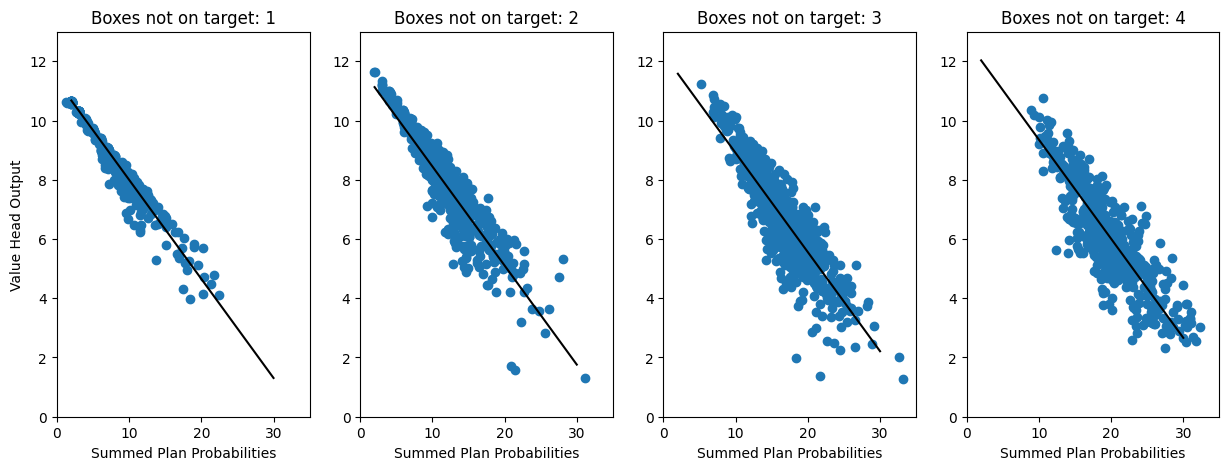

In [136]:
fig, axs = plt.subplots(1,4, figsize=(15,5))
for j in range(1,5):
    axs[j-1].scatter([p[0] for p in plans if p[1] == j], [vals[i] for i in range(len(vals)) if plans[i][1]==j])
    axs[j-1].plot(np.linspace(start=2,stop=30), [reg.predict([[i,j]]) for i in np.linspace(start=2,stop=30)], color="black")
    axs[j-1].set_ylim(0,13)
    axs[j-1].set_xlim(0,35)
    axs[j-1].set_title(f"Boxes not on target: {j}")
    axs[j-1].set_xlabel("Summed Plan Probabilities")
axs[0].set_ylabel("Value Head Output")
plt.show()